In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
#%matplotlib notebook
import cmcrameri.cm as cmc  #scientific color maps - perceptually uniform
from scipy import signal
from scipy.optimize import fsolve
from scipy.stats import norm
from sklearn.preprocessing import normalize
import cmcrameri.cm as cmc  #scientific color maps - perceptually uniform
from scipy import constants
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

In [19]:

def Gau(x: np.array, mu: float, sigma: float | int) -> np.array:
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

def extinction(WL:np.array, epsilon_max:float, sigma:float, mu:float) -> np.array:
    return epsilon_max * Gau(WL, mu, sigma)/max(Gau(WL, mu, sigma))

def calcaulate_theta(U0: float, U: np.array) -> np.array:
    R = constants.R
    F = constants.physical_constants['Faraday constant'][0]  # Extract the numerical value
    T_K = 298.15
    exp_fun = np.exp(((U - U0) * F) / (R * T_K))
    return exp_fun / ( exp_fun + 1)

def evolve_concentration(theta:np.array, C0:float,  product_bool:bool, stoic_coef:float) -> np.array:
    if product_bool:
        return theta * C0  * stoic_coef
    else:
        return (1 - theta) * C0 
    

def evolve_spectrum(epsilon:np.array, C0:float, theta:np.array, product_bool:bool, stoic_coef:float) -> pd.DataFrame:
   conc =evolve_concentration(theta=theta, C0=C0, product_bool=product_bool, stoic_coef=stoic_coef)
   conc_reshaped=conc.reshape(1,conc.shape[0])
   epsilon_reshaped=epsilon.reshape(epsilon.shape[0],1)
   if  epsilon_reshaped.shape[1] != conc_reshaped.shape[0]:
       raise ValueError(f'The dimensions of  the extinction coefficient ({epsilon_reshaped.shape}) the concentration ({conc_reshaped.shape}) and do not match')
   return pd.DataFrame(epsilon_reshaped@conc_reshaped)

In [20]:
muWL_L=(450,500,575)
sigma_L=(20,20,10)
epsilon=[150,250,100] # molar extinction coeffcients
WL_arr=np.arange(400,900,1)
U = np.linspace(0.3, 0.7, 1000)
U0=0.5
C0=0.001 # in mol/L

plt.rcParams['figure.dpi'] = 200


In [21]:
theta=calcaulate_theta(U0=U0, U=U)
species_labels=['A','B','C']


epsilon_dict={}

for i,  (mu, sigma, eps) in enumerate(zip(muWL_L, sigma_L, epsilon)):
    epsilon_dict[f'{species_labels[i]}'] = extinction(WL_arr, epsilon_max=eps, sigma=sigma, mu=mu)
    


for i, epsilon in enumerate(epsilon_dict):
    if i == 0:
        A_SpEC=pd.DataFrame()
        A_SpEC=evolve_spectrum(epsilon=epsilon_dict[epsilon], C0=C0, theta=theta, product_bool=False, stoic_coef=1)
    else:
        A_SpEC+=evolve_spectrum(epsilon=epsilon_dict[epsilon], C0=C0, theta=theta, product_bool=True, stoic_coef=1)
        
A_SpEC.index=WL_arr
A_SpEC.columns=U


A_SpECN=A_SpEC.div(A_SpEC.max(axis=0), axis=1)

conc_dict={}
for i, epsilon in enumerate(epsilon_dict):
    if i == 0:
        conc_dict[f'{species_labels[i]}'] = evolve_concentration(theta=theta, C0=C0, product_bool=False, stoic_coef=1)
    else:
        conc_dict[f'{species_labels[i]}'] = evolve_concentration(theta=theta, C0=C0, product_bool=True, stoic_coef=1)



A
B
C


/var/folders/vm/d986p9hx0rlglk34b43v_h180000gn/T/ipykernel_17057/2298279498.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1[0].set_yticklabels([f'{i*1000:.0f}' for i in ax1[0].get_yticks()])


Text(0.5, 0, 'U (V)')

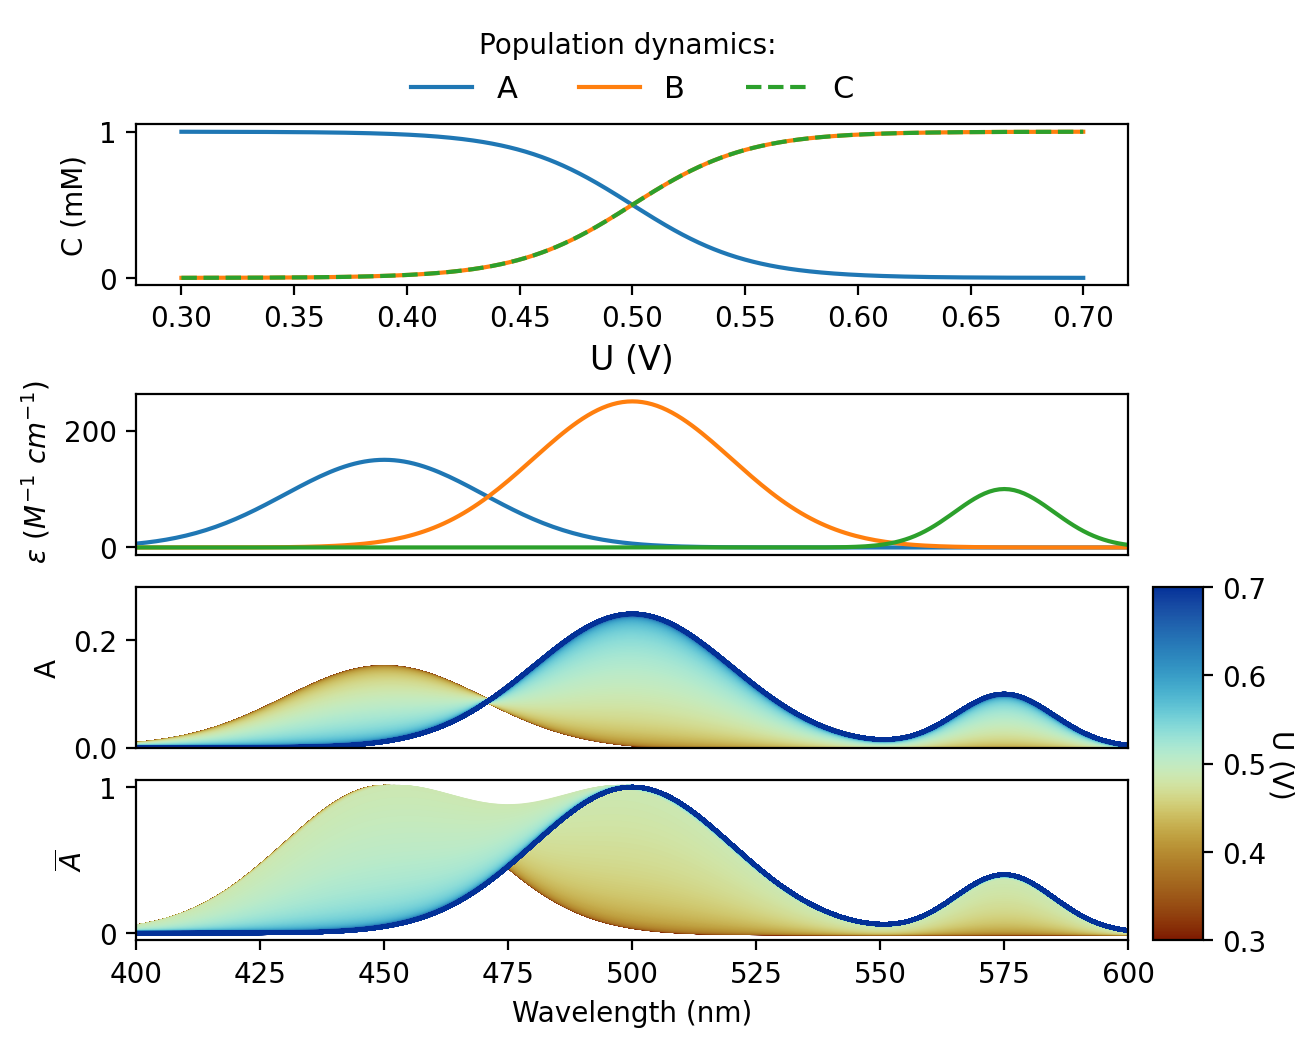

In [22]:
# triple plot of the concentration, extinction coefficient and absorbancen dynamics

fig1, ax1 = plt.subplots(nrows=4)

for (key, conc) in conc_dict.items():
    print(key)
    if key!='C':
        pd.DataFrame(conc, index=U).plot(ax=ax1[0], legend=True, label=key)
    else:    
        pd.DataFrame(conc, index=U).plot(ax=ax1[0], legend=True, linestyle='--', label=key)
ax1[0].legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.7), ncol=3, fontsize=11)

# rename the ledgend labels [A, B, C]
ax1[0].legend(['A', 'B', 'C'], frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.75), ncol=3, fontsize=11)

# add a legend title to the legend
ax1[0].get_legend().set_title(r'Population dynamics: ', prop={'size': 10})

# multiply the y-axis by 1000 to convert from mol/L to mmol/L
ax1[0].set_ylabel('C (mM)', fontsize=10)
# change the y ticks to mmol/L
ax1[0].set_yticklabels([f'{i*1000:.0f}' for i in ax1[0].get_yticks()])

epsilons=pd.DataFrame(epsilon_dict, index=WL_arr)
epsilons.plot(ax=ax1[1], legend=False)
ax1[1].set_xlim(400,600)


ax1[1].set_xlabel('Wavelength (nm)', fontsize=10)
ax1[1].set_ylabel(r' $\epsilon \ (M^{-1} \ cm^{-1})$ ', fontsize=10)



A_SpEC.plot(ax=ax1[2], cmap=cmc.roma, legend=False)
ax1[2].set_xlabel('Wavelength (nm)', fontsize=10)
ax1[2].set_ylabel(r'A', fontsize=10)
ax1[2].set_xlim(400,600)
ax1[2].set_ylim(-0,0.3)

A_SpECN.plot(ax=ax1[3], cmap=cmc.roma, legend=False)
ax1[3].set_xlabel('Wavelength (nm)', fontsize=10)
ax1[3].set_ylabel(r'$\overline{A}$', fontsize=10)

#create a color bar for ax1[2]
sm = pl.cm.ScalarMappable(cmap=cmc.roma, norm=plt.Normalize(vmin=A_SpEC.columns.values.min(), vmax=A_SpEC.columns.values.max()))



# Add the colorbar to the figure using inset_axes
cax = inset_axes(ax1[2], width="5%", height="50%", loc='center', bbox_to_anchor=(0.55, -2.3,1, 4.4), bbox_transform=ax1[2].transAxes, borderpad=0)
fig1.colorbar(sm, cax=cax, orientation='vertical')

#add a title to the colorbar and place it on the right side of the colorbar
cax.yaxis.set_label_position("right")
cax.yaxis.set_ticks_position("right")
cax.set_ylabel('U (V)', rotation=270, fontsize=10, labelpad=10)

# drop the x-axis labels, ticks and title for ax1[1]
ax1[1].set_xticklabels([])
ax1[1].set_xticks([])
ax1[1].set_xlabel('')

# drop the x-axis labels, ticks and title for ax1[2]
ax1[2].set_xticklabels([])
ax1[2].set_xticks([])
ax1[2].set_xlabel('')
# x-axis range for ax1[2] 400 to 600
ax1[2].set_xlim(400,600)
ax1[3].set_xlim(400,600)
# remove the white space between ax1 and ax 2
# Adjust the positions of the subplots to remove white space between ax1[1] and ax1[2]
pos0 = ax1[0].get_position()
# pos1 = ax1[1].get_position()
# pos2 = ax1[2].get_position()
# pos3 = ax1[3].get_position()

# # Set new positions
ax1[0].set_position([pos0.x0, pos0.y0+0.08, pos0.width, pos0.height])
# ax1[1].set_position([pos1.x0, pos1.y0 - 0.035, pos1.width, pos1.height])
# ax1[2].set_position([pos2.x0, pos2.y0 + 0.005, pos2.width, pos2.height])
# ax1[3].set_position([pos3.x0, pos3.y0 + 0.055, pos3.width, pos3.height])

# add a x axis label for ax 1
ax1[0].set_xlabel('U (V)', fontsize=12)



$\Delta  \epsilon$,  dimensions: $Mol^{-1} dm^3 cm$ 
$\\$
SI Dimensions are : $ Mol^{-1} cm^2$

Conversion to $\Delta  \epsilon$ to molar attenuation cross section: $10^3*\epsilon=\sigma_m$
Conversion to coulmetric attenuation 

$\frac{10^3*\epsilon}{F}=\alpha$

Likewise concentrations convert to charge per cm-2 assuming 1 e- with:

$Q=\frac{CF}{10^3}$

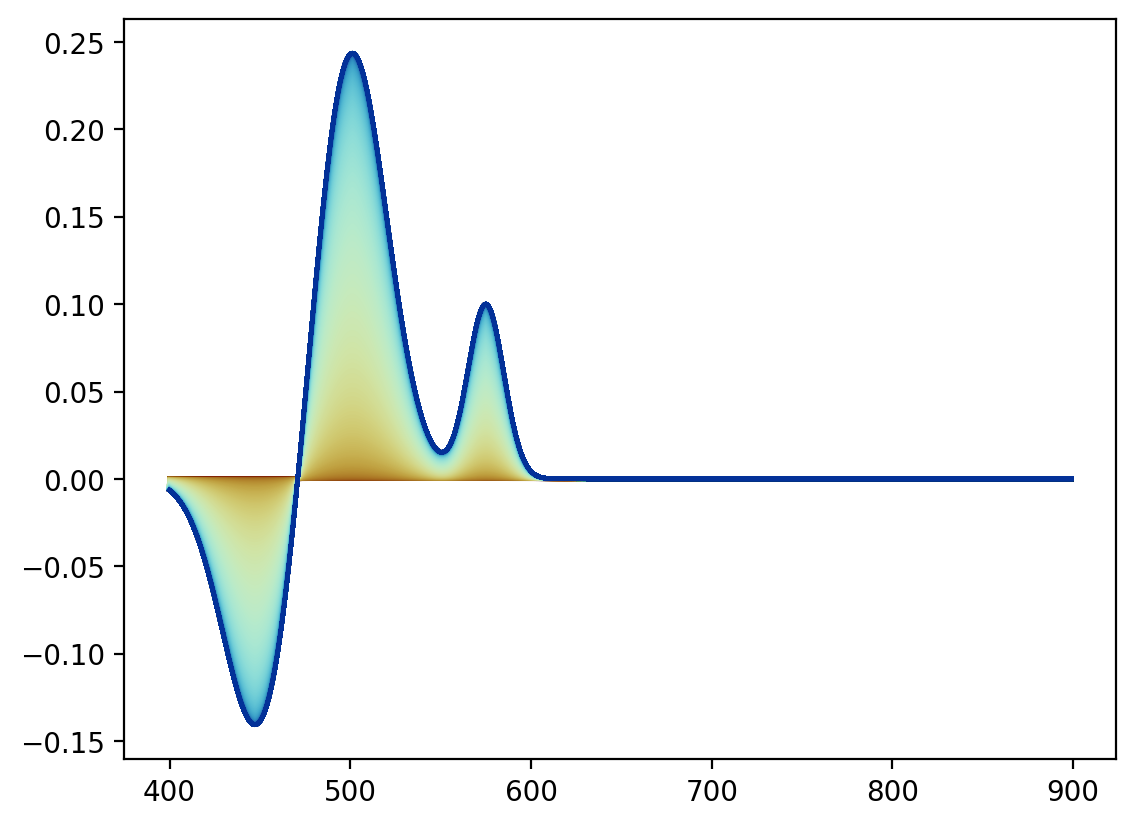

In [23]:
# the change in conctration as charge is just conc of B times F with 10 with area conversion to cm-2

Q_B=(conc_dict['B']*constants.physical_constants['Faraday constant'][0])/10**3

# calculating the differential extinction coefficent which is epsilon_dict['B']+epsilon_dict['C']-epsilon_dict['A']
diff_eps=epsilon_dict['B']+epsilon_dict['C']-epsilon_dict['A']

# to convert from M^-1 cm-1 to CM^-1 cm^2 we need to divide by 10^3*F

diff_alpha=10**3*diff_eps/(constants.physical_constants['Faraday constant'][0])

#pd.DataFrame(diff_alpha, index=WL_arr).plot()

Delta_A=evolve_spectrum(epsilon=diff_alpha, C0=Q_B[-1], theta=theta, product_bool=True, stoic_coef=1)
Delta_A.columns=U
Delta_A.index=WL_arr
Delta_A.plot(legend=False, colormap=cmc.roma)

Delta_AN=Delta_A.div(Delta_A.max(axis=0), axis=1)


Text(0.5, 1.0, 'Process dynamics')

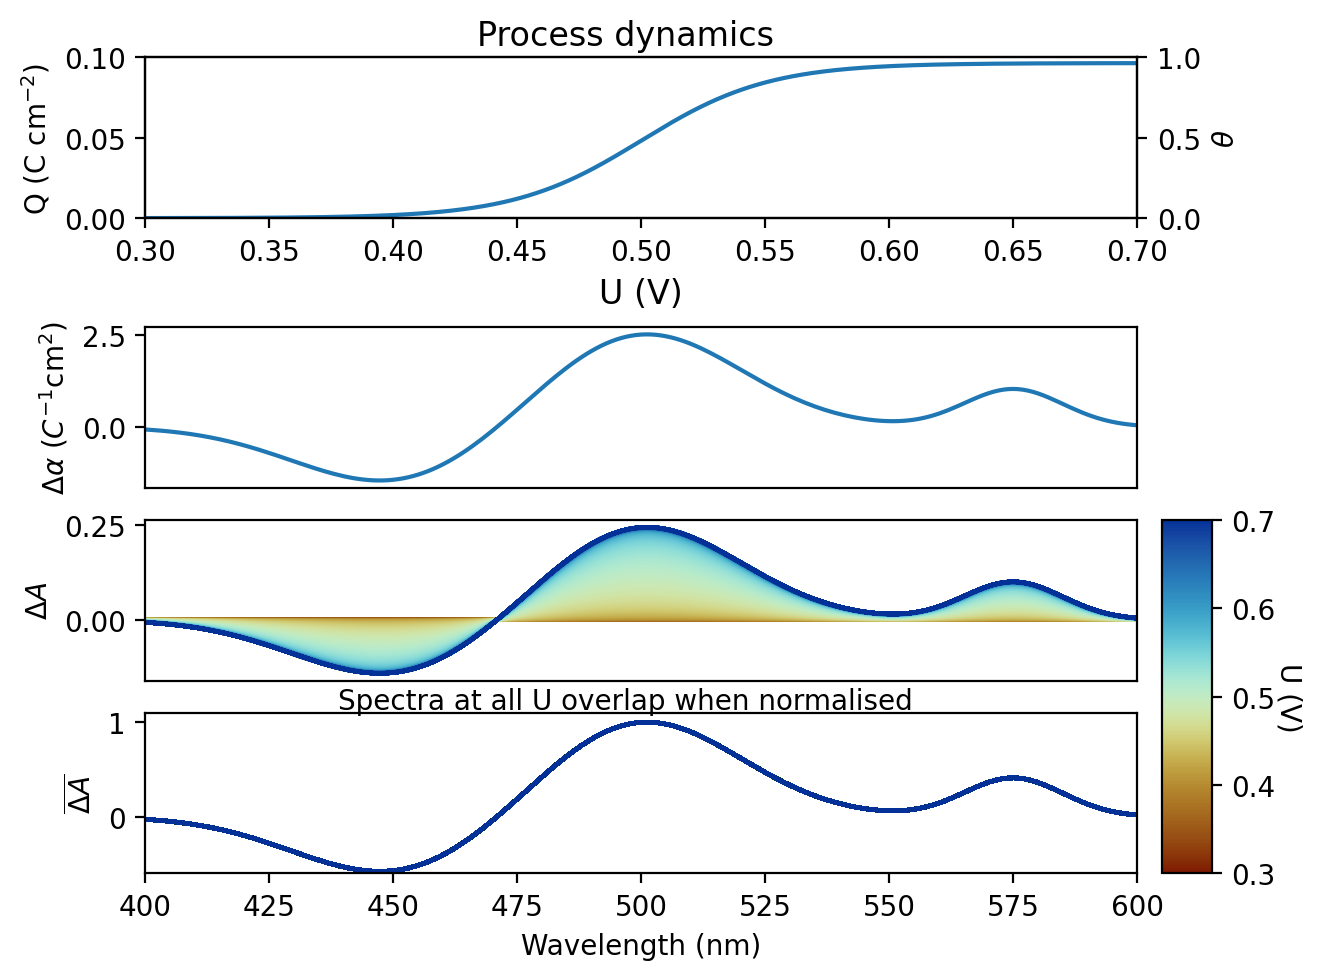

In [24]:

# make a triple plot of the Charge, attenuation coefficient and differential absorbance dynamics
fig2, ax2 = plt.subplots(nrows=4)

Q_B=pd.DataFrame(Q_B, index=U)

Q_B.plot(ax=ax2[0], legend=False)


ax2[0].set_ylabel('Q (C cm$^{-2}$)', fontsize=10)
ax2[0].set_xlabel('U (V)', fontsize=10)
ax2[0].set_xlim(0.3,0.7)
ax2[0].set_ylim(0,0.1)

# add a second y-axis to ax2[0] to convert from C to mol
ax2_0_sec=ax2[0].twinx()
# set the ticks to be between 0 and 1
ax2_0_sec.set_yticks(np.arange(0, 1.1, 0.5))
# label the axis title
ax2_0_sec.set_ylabel(r'$\theta$', fontsize=10)



diff_alpha_df=pd.DataFrame(diff_alpha, index=WL_arr)
diff_alpha_df.plot(ax=ax2[1], legend=False)
ax2[1].set_ylabel(r'$\Delta \alpha$ ($C^{-1}$cm$^2$)', fontsize=10)
ax2[1].set_xlabel('Wavelength (nm)', fontsize=10)
ax2[1].set_xlim(400,600)

Delta_A.plot(ax=ax2[2], legend=False, colormap=cmc.roma)
ax2[2].set_ylabel(r'$\Delta A$', fontsize=10)
ax2[2].set_xlabel('Wavelength (nm)', fontsize=10)
ax2[2].set_xlim(400,600)

ax2[3].set_xlabel('Wavelength (nm)', fontsize=10)
ax2[3].set_ylabel(r'$\overline{\Delta A}$', fontsize=10)
ax2[3].set_ylim(-0.6,1.1)

Delta_AN.plot(ax=ax2[3], legend=False, colormap=cmc.roma)
#create a color bar for ax2[2]
sm = pl.cm.ScalarMappable(cmap=cmc.roma, norm=plt.Normalize(vmin=Delta_A.columns.values.min(), vmax=Delta_A.columns.values.max()))

# Add the colorbar to the figure using inset_axes
cax = inset_axes(ax1[2], width="5%", height="50%", loc='center', bbox_to_anchor=(0.55, -2.3,1, 4.4), bbox_transform=ax1[2].transAxes, borderpad=0)
fig2.colorbar(sm, cax=cax, orientation='vertical')
#add a title to the colorbar and place it on the right side of the colorbar
cax.yaxis.set_label_position("right")
cax.yaxis.set_ticks_position("right")
cax.set_ylabel('U (V)', rotation=270, fontsize=10, labelpad=10)

# drop the x-axis labels, ticks and title for ax2[1]
ax2[1].set_xticklabels([])
ax2[1].set_xticks([])
ax2[1].set_xlabel('')
# remove the white space between ax2 and ax 3
# Adjust the positions of the subplots to remove white space between ax2[1] and ax2[2]
pos0 = ax2[0].get_position()


# Add the colorbar to the figure using inset_axes
cax = inset_axes(ax2[2], width="5%", height="50%", loc='center', bbox_to_anchor=(0.55, -2.3,1, 4.4), bbox_transform=ax2[2].transAxes, borderpad=0)
fig2.colorbar(sm, cax=cax, orientation='vertical')

#add a title to the colorbar and place it on the right side of the colorbar
cax.yaxis.set_label_position("right")
cax.yaxis.set_ticks_position("right")
cax.set_ylabel('U (V)', rotation=270, fontsize=10, labelpad=10)

# drop the x-axis labels, ticks and title for ax1[1]
ax2[1].set_xticklabels([])
ax2[1].set_xticks([])
ax2[1].set_xlabel('')

# drop the x-axis labels, ticks and title for ax1[2]
ax2[2].set_xticklabels([])
ax2[2].set_xticks([])
ax2[2].set_xlabel('')
# x-axis range for ax1[2] 400 to 600
ax2[2].set_xlim(400,600)
ax2[3].set_xlim(400,600)
# remove the white space between ax1 and ax 2
# Adjust the positions of the subplots to remove white space between ax1[1] and ax1[2]
pos0 = ax1[0].get_position()
# pos1 = ax1[1].get_position()
# pos2 = ax1[2].get_position()
# pos3 = ax1[3].get_position()

# # Set new positions
ax2[0].set_position([pos0.x0, pos0.y0, pos0.width, pos0.height])
# ax1[1].set_position([pos1.x0, pos1.y0 - 0.035, pos1.width, pos1.height])
# ax1[2].set_position([pos2.x0, pos2.y0 + 0.005, pos2.width, pos2.height])
# ax1[3].set_position([pos3.x0, pos3.y0 + 0.055, pos3.width, pos3.height])

# add text just above ax 3
fig2.text(0.5, 0.29, 'Spectra at all U overlap when normalised', ha='center', va='center', fontsize=10)
# add a x axis label for ax 1
ax2[0].set_xlabel('U (V)', fontsize=12)

# add a title to the figure
fig2.suptitle('Process dynamics', fontsize=12, y=1.0)



In [25]:
muWL_L=(450,500,575)
sigma_L=(20*5,20*5,10*5)
epsilon=[150,250,100] # molar extinction coeffcients
WL_arr=np.arange(400,900,1)
U = np.linspace(0.3, 0.7, 1000)
U0=0.5
C0=0.001 # in mol/L

In [26]:
theta=calcaulate_theta(U0=U0, U=U)
species_labels=['A','B','C']


epsilon_dict2={}

for i,  (mu, sigma, eps) in enumerate(zip(muWL_L, sigma_L, epsilon)):
    epsilon_dict2[f'{species_labels[i]}'] = extinction(WL_arr, epsilon_max=eps, sigma=sigma, mu=mu)
    


for i, epsilon in enumerate(epsilon_dict):
    if i == 0:
        A_SpEC2=pd.DataFrame()
        A_SpEC2=evolve_spectrum(epsilon=epsilon_dict2[epsilon], C0=C0, theta=theta, product_bool=False, stoic_coef=1)
    else:
        A_SpEC2+=evolve_spectrum(epsilon=epsilon_dict2[epsilon], C0=C0, theta=theta, product_bool=True, stoic_coef=1)
        
A_SpEC2.index=WL_arr
A_SpEC2.columns=U

conc_dict={}
for i, epsilon in enumerate(epsilon_dict2):
    if i == 0:
        conc_dict[f'{species_labels[i]}'] = evolve_concentration(theta=theta, C0=C0, product_bool=False, stoic_coef=1)
    else:
        conc_dict[f'{species_labels[i]}'] = evolve_concentration(theta=theta, C0=C0, product_bool=True, stoic_coef=1)




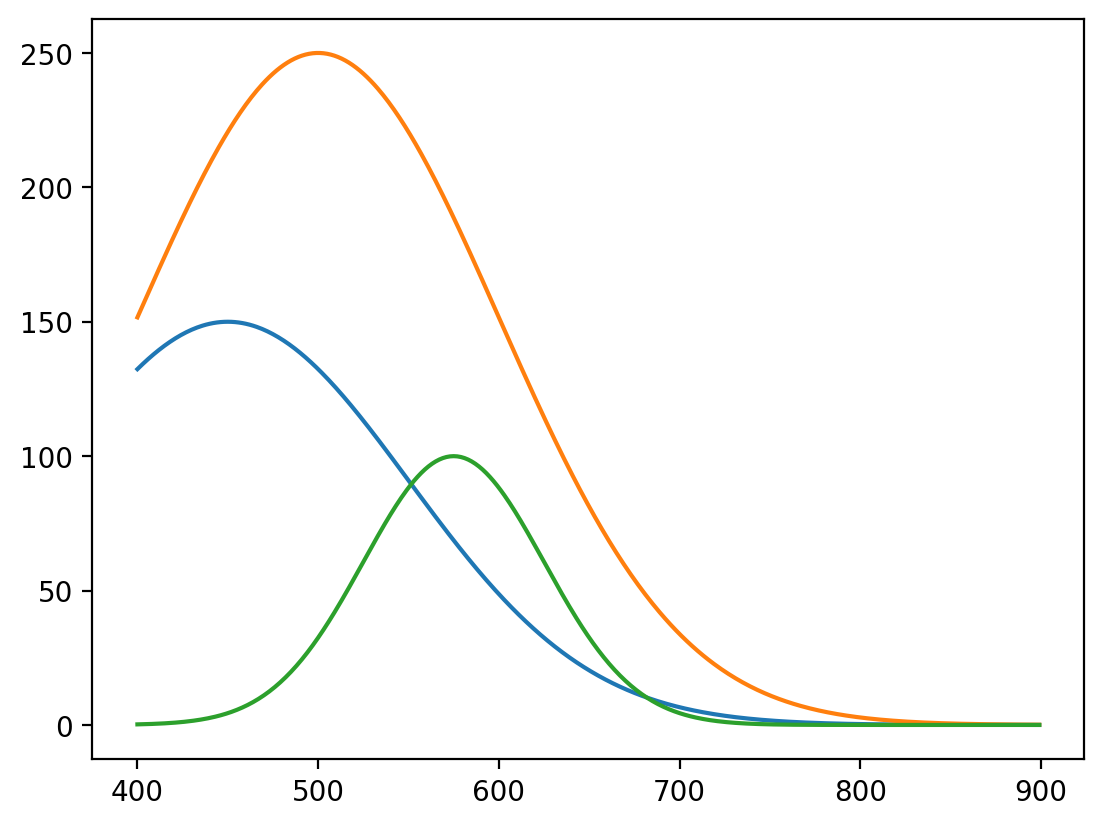

In [27]:
# plot epsilon dict 

for key, epsilon in epsilon_dict2.items():
    plt.plot(WL_arr, epsilon, label=key)
    

In [28]:
# generate a large background absorbance spectrum using gau
muBG=[100,450,500]
sigmaBG=[100,200,50]

for i,  (mu, sigma) in enumerate(zip(muBG, sigmaBG)):
    if i == 0:
        Gau_BG=extinction(WL_arr, epsilon_max=1, sigma=sigma, mu=mu)
    else:
        Gau_BG+=extinction(WL_arr, epsilon_max=1, sigma=sigma, mu=mu)


# add A_SpEC to the background spectrum
A_SpEC_BG=A_SpEC2.add(Gau_BG,axis=0)



Delta_A_BG=A_SpEC_BG.subtract(A_SpEC_BG.iloc[:,0], axis=0)
# x range 400 to 600

A_SpEC2N=A_SpEC2.div(A_SpEC2.max(axis=0), axis=1)
Delta_A_BG_N=Delta_A_BG.div(Delta_A_BG.max(axis=0), axis=1)



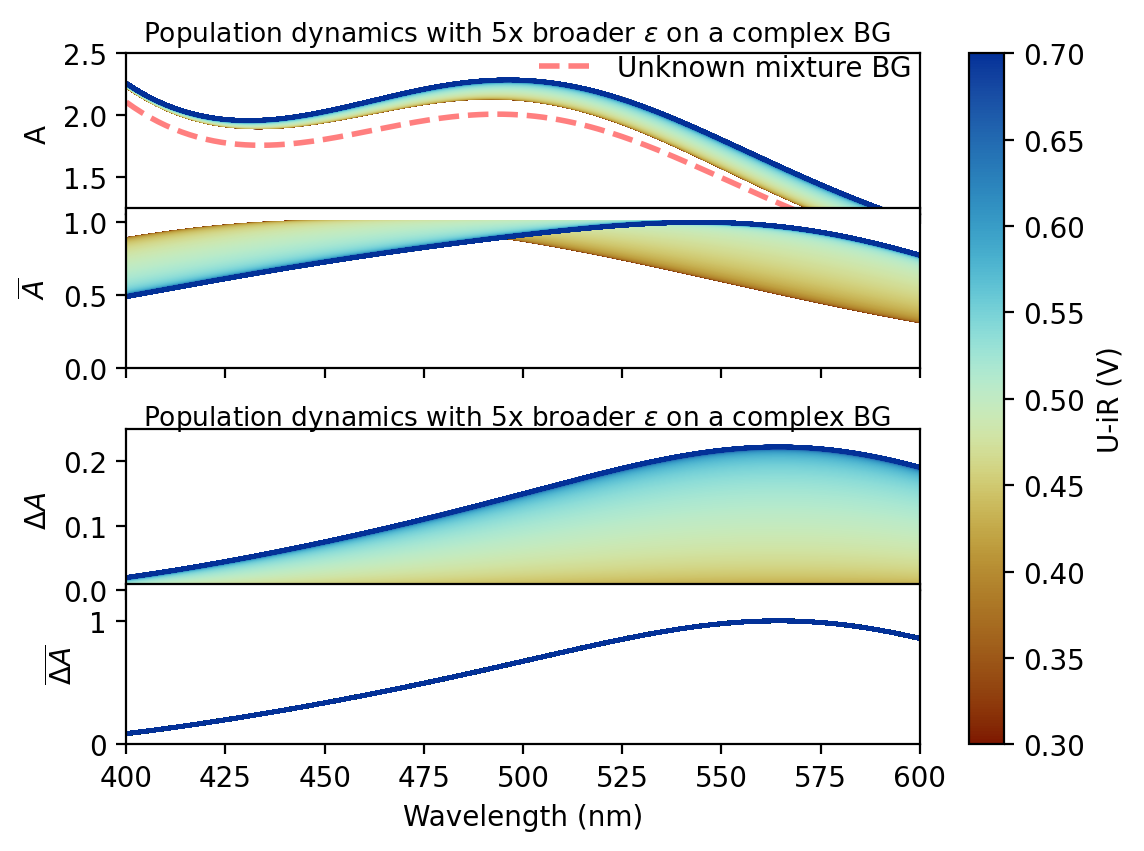

In [29]:
fig4, ax4 = plt.subplots(nrows=4, sharex=True)

A_SpEC_BG.plot(colormap=cmc.roma, legend=False, ax=ax4[0])
# ax4[0].plot(WL_arr, Gau_BG,  alpha=1, color='red', linewidth=2, label='Unknown BG')
# ax4[0].legend(['Unknown BG'], frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.7), ncol=4, fontsize=11)
# Plot Gau_BG with legend
line, = ax4[0].plot(WL_arr, Gau_BG, linestyle='--', alpha=0.5, color='red', linewidth=2, label='Unknown mixture BG')

# Set legend for ax4[0]
ax4[0].legend(handles=[line], frameon=False, loc='upper center', bbox_to_anchor=(0.755, 1.15),  fontsize=10)
# ax4[0].set_xlim(400,600)
ax4[0].set_ylim(1.2,2.5)


ax4[2].set_ylim(-0.,0.3)
ax4[1].set_ylim(0,1.1)

Delta_A_BG.plot(colormap=cmc.roma, legend=False, ax=ax4[2])
A_SpEC2N.plot(colormap=cmc.roma, legend=False,ax=ax4[1])
Delta_A_BG_N.index=WL_arr
Delta_A_BG_N.plot(colormap=cmc.roma, legend=False, ax=ax4[3])

# # remove the ticks and labels from the x-axis of ax4[0]
# ax4[0].set_xticks([])
# ax4[0].set_xticklabels([])
# ax4[0].set_xlabel('')

# ax4[1].set_xticks([])
# ax4[1].set_xticklabels([])
# ax4[1].set_xlabel('')

# ax4[2].set_xticks([])
# ax4[2].set_xticklabels([])



# get the position of all the subplots
pos0 = ax4[0].get_position()
pos1 = ax4[1].get_position()
pos2 = ax4[2].get_position()
pos3 = ax4[3].get_position()

# Set new positions
ax4[1].set_position([pos1.x0, pos1.y0 + 0.04, pos1.width, pos1.height])
ax4[2].set_position([pos2.x0, pos2.y0 + 0.01, pos2.width, pos2.height])
ax4[3].set_position([pos3.x0, pos3.y0 + 0.05, pos3.width, pos3.height])

# set y range for ax 2
ax4[2].set_ylim(0,0.25)
ax4[3].set_ylim(-0,1.3)

xrange=(400,600)
ax4[0].set_xlim(xrange)
ax4[1].set_xlim(xrange)
ax4[2].set_xlim(xrange)
ax4[3].set_xlim(xrange)


#add y ticks every 0.1 for ax4[2]
ax4[2].set_yticks(np.arange(0, 0.3, 0.1))
ax4[1].set_yticks(np.arange(0, 1.5, 0.5))

# add axis labels to ax4[3]
ax4[3].set_xlabel('Wavelength (nm)', fontsize=10)

#add ledgend to ax4[0] that contains only the background spectrum with the red dashed line

# add a scalar mappable for a color bar
sm = pl.cm.ScalarMappable(cmap=cmc.roma, norm=plt.Normalize(vmin=A_SpEC2.columns.values.min(), vmax=A_SpEC2.columns.values.max()))

# Add the colorbar to the figure

fig4.colorbar(ax=ax4, mappable=sm,
              label=r'U-iR (V)')

# y labels for all the subplots are A, $\overline{A}$, $\Delta A$ and $\overline{\Delta A}$
ax4[0].set_ylabel(r'A', fontsize=10)
ax4[1].set_ylabel(r'$\overline{A}$', fontsize=10)
ax4[2].set_ylabel(r'$\Delta A$', fontsize=10)
ax4[3].set_ylabel(r'$\overline{\Delta A}$', fontsize=10)

# add text on top of ax4[0] 
fig4.text(0.43, 0.9, r'Population dynamics with 5x broader $\epsilon$ on a complex BG', ha='center', va='center', fontsize=9.5)

# add text on top of ax4[2]
fig4.text(0.43, 0.5, r'Population dynamics with 5x broader $\epsilon$ on a complex BG', ha='center', va='center', fontsize=9.5)

#the figure needs anti-aliasing
plt.show()

